In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import numpy as np
import matplotlib.pyplot as plt
from sns_toolbox.networks import Network #, AdditionNetwork (This would import the code that we remake here
from sns_toolbox.neurons import NonSpikingNeuron
from sns_toolbox.connections import NonSpikingSynapse
from sns_toolbox.neurons import  NonSpikingNeuronWithPersistentSodiumChannel
from sns_toolbox.renderer import render

In [2]:
class Memory(Network):
    """
    Memory netwok
    :param name:        Name of this network and all neurons prefix. Should be Bump/Step/Gait. Default is 'Bump'.
    :type:              Can be Auto/Manual, Default is 'Auto'
        Auto network will automatically keep from resetting when it has a value, manual will autoreset unless the reset is suppressed otherwise
    """
    def __init__(self,name='Bump', type='Auto'):
        super().__init__(name=name)

        # Establish Key Variables

        Er = -60 # mV, resting potential, base state of neurons which they move off of
        Gm = 1 # uS
        R = 20 # mV, standing current applied to both integrator neurons to keep the system stable

        # Neuron variables based on table
        Cm = 5
        Es = -65 # Want synapse close to Er but a little less because close to modulatory is good but actually modulatory won't work
        delEs = Es-Er
        gs = -R/delEs

        intNeuron = NonSpikingNeuron(name="Int", color="lightgreen", membrane_capacitance=Cm, membrane_conductance=Gm, resting_potential=Er, bias=R)
        intSynapse = NonSpikingSynapse(max_conductance=gs, reversal_potential=Es, e_hi=-40, e_lo=-60)
        if name == 'Bump':
            INNeuron = NonSpikingNeuron(name="Int", color="salmon", membrane_capacitance=30, membrane_conductance=Gm, resting_potential=Er, bias=3)
        elif name == 'Gait':
            INNeuron = NonSpikingNeuron(name="Int", color="salmon", membrane_capacitance=20, membrane_conductance=Gm, resting_potential=Er)
        else:
            INNeuron = NonSpikingNeuron(name="Int", color="salmon", membrane_capacitance=20, membrane_conductance=Gm, resting_potential=Er, bias=3)
        # TriggerSynapse = NonSpikingSynapse(max_conductance=30, reversal_potential=0, e_hi=-35, e_lo=-55)
        InhSyn = NonSpikingSynapse(max_conductance=5, reversal_potential=-100, e_hi=-40, e_lo=-58) # max conductance mainly effects strength, reversal potential
        # mainly effects function, if inh then -100, if exc then 0
        # e_hi and e_lo determine the range over which the synapse activates
        ResetDoneSyn = NonSpikingSynapse(max_conductance=3, reversal_potential=-100, e_hi=-70, e_lo=-60)

        self.add_neuron(intNeuron, name+'_RMem')
        self.add_neuron(intNeuron, name+'_Mem')
        self.add_neuron(INNeuron, name+'_Reset')

        self.add_connection(intSynapse, name+'_RMem', name+'_Mem')
        self.add_connection(intSynapse, name+'_Mem', name+'_RMem')
        self.add_connection(InhSyn, name+'_Reset', name+'_Mem')
        self.add_connection(ResetDoneSyn, name+'_Mem', name+'_Reset')

        self.add_input(name+'_Reset', name='Input')

        if type == 'Auto':
            if name == 'Gait':
                AntiResetSyn = NonSpikingSynapse(max_conductance=0.1, reversal_potential=-100, e_hi=-50, e_lo=-61)
            else:
                AntiResetSyn = NonSpikingSynapse(max_conductance=0.1, reversal_potential=-100, e_hi=-50, e_lo=-57)
            self.add_connection(AntiResetSyn,name+'_Mem', name+'_Reset')
            if name == 'Bump':
                self.add_input(name+'_Mem', name='Stimulus')

        self.add_output(name+'_Mem')
        self.add_output(name+'_RMem')
        self.add_output(name+'_Reset')


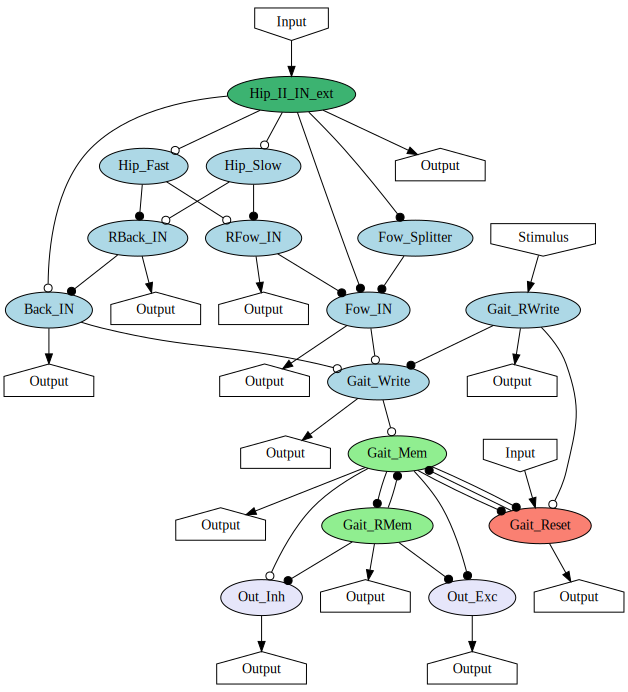

In [3]:
net = Network('Gait Net')

# Establish Key Variables

Er = -60 # mV
Gm = 1 # uS
R = 20 # mV

# Add hip II flx
base_neuron = NonSpikingNeuron(membrane_capacitance=5.0, membrane_conductance=1, resting_potential=-60)
net.add_neuron(base_neuron, name='Hip_II_IN_ext', color='mediumseagreen') # As flx value increases, leg moves backward
net.add_input('Hip_II_IN_ext')
net.add_output('Hip_II_IN_ext')

############################## Gait NETWORK ############################
# FAST AND SLOW NEURONS
Fast = NonSpikingNeuron(membrane_capacitance=1.0, membrane_conductance=1, resting_potential=-60)
net.add_neuron(Fast, name='Hip_Fast', color='lightblue')
Slow = NonSpikingNeuron(membrane_capacitance=30.0, membrane_conductance=1, resting_potential=-60)
net.add_neuron(Slow, name='Hip_Slow', color='lightblue')
IIDeriv = NonSpikingSynapse(max_conductance=0.1, reversal_potential=0, e_hi=-40, e_lo=-60)
net.add_connection(IIDeriv, 'Hip_II_IN_ext', 'Hip_Fast')
net.add_connection(IIDeriv, 'Hip_II_IN_ext', 'Hip_Slow')

# DERIVATIVE NETWORK
net.add_neuron(base_neuron, name='RBack_IN', color='lightblue')
net.add_output('RBack_IN')
net.add_neuron(base_neuron, name='RFow_IN', color='lightblue')
net.add_output('RFow_IN')
DerivExc = NonSpikingSynapse(max_conductance=50, reversal_potential=0, e_hi=-40, e_lo=-60)
DerivInh = NonSpikingSynapse(max_conductance=40, reversal_potential=-100, e_hi=-40, e_lo=-60)
net.add_connection(DerivExc, 'Hip_Fast', 'RFow_IN')
net.add_connection(DerivExc, 'Hip_Slow', 'RBack_IN')
net.add_connection(DerivInh, 'Hip_Fast', 'RBack_IN')
net.add_connection(DerivInh, 'Hip_Slow', 'RFow_IN')

# ACTUAL OPERATORS
BackNeuron = NonSpikingNeuron(membrane_capacitance=1.0, membrane_conductance=1, resting_potential=-60, bias=4.5)
net.add_neuron(BackNeuron, name='Back_IN', color='lightblue')
net.add_output('Back_IN')
FowNeuron = NonSpikingNeuron(membrane_capacitance=1.0, membrane_conductance=1, resting_potential=-60, bias=12)
net.add_neuron(FowNeuron, name='Fow_IN', color='lightblue')
net.add_output('Fow_IN')
RSuppression = NonSpikingSynapse(max_conductance=20, reversal_potential=-65, e_hi=-40, e_lo=-45.85)
net.add_connection(RSuppression, 'RBack_IN', 'Back_IN')
net.add_connection(RSuppression, 'RFow_IN', 'Fow_IN')
HipExc = NonSpikingSynapse(max_conductance=0.05, reversal_potential=0, e_hi=-45, e_lo=-54)
net.add_connection(HipExc, 'Hip_II_IN_ext', 'Back_IN')
HipInh = NonSpikingSynapse(max_conductance=0.13, reversal_potential=-100, e_hi=-45, e_lo=-54)
net.add_connection(HipInh, 'Hip_II_IN_ext', 'Fow_IN')

# EXTRA FOW_IN OPERATOR
FowSplitter = NonSpikingNeuron(membrane_capacitance=5.0, membrane_conductance=1, resting_potential=-60, bias=5)
net.add_neuron(FowSplitter, name='Fow_Splitter', color='lightblue')
HipSplitSyn = NonSpikingSynapse(max_conductance=20, reversal_potential=-65, e_hi=-40, e_lo=-48.5)
net.add_connection(HipSplitSyn, 'Hip_II_IN_ext', 'Fow_Splitter')
FowSplitSyn = NonSpikingSynapse(max_conductance=3, reversal_potential=-65, e_hi=-45, e_lo=-58)
net.add_connection(FowSplitSyn, 'Fow_Splitter', 'Fow_IN')

# Gait Write
GaitRWrite = NonSpikingNeuron(membrane_capacitance=5.0, membrane_conductance=1, resting_potential=-60, bias = 10)
net.add_neuron(GaitRWrite, name='Gait_RWrite', color='lightblue')
net.add_input('Gait_RWrite', name='Stimulus')
net.add_output('Gait_RWrite')
GaitWrite = NonSpikingNeuron(membrane_capacitance=1.0, membrane_conductance=1, resting_potential=-60)
net.add_neuron(GaitWrite, name='Gait_Write', color='lightblue')
net.add_output('Gait_Write')
WriteBlock = NonSpikingSynapse(max_conductance=20, reversal_potential=-60, e_hi=-40, e_lo=-60)
net.add_connection(WriteBlock, 'Gait_RWrite', 'Gait_Write')
WriteIn = NonSpikingSynapse(max_conductance=1, reversal_potential=0, e_hi=-45, e_lo=-58)
net.add_connection(WriteIn, 'Back_IN', 'Gait_Write')
net.add_connection(WriteIn, 'Fow_IN', 'Gait_Write')


# GATE STORAGE
Gait_Storage = Memory(name='Gait', type='Auto')
net.add_network(Gait_Storage)
ResetBase = NonSpikingSynapse(max_conductance=0.05, reversal_potential=0, e_hi=-45, e_lo=-60)
net.add_connection(ResetBase, 'Gait_RWrite', 'Gait_Reset')
WriteOut = NonSpikingSynapse(max_conductance=0.4, reversal_potential=0, e_hi=-35, e_lo=-57)
net.add_connection(WriteOut,'Gait_Write', 'Gait_Mem')

# OUTPUT INTERNEURONS
OutExc = NonSpikingNeuron(membrane_capacitance=10.0, membrane_conductance=1, resting_potential=-60, bias = 19)
net.add_neuron(OutExc, name='Out_Exc', color='lavender') # Neuron that slows down the RG
net.add_output('Out_Exc')
MemOutInh = NonSpikingSynapse(max_conductance=0.50, reversal_potential=-100, e_hi=-47.5, e_lo = -57.5)
net.add_connection(MemOutInh, 'Gait_Mem', 'Out_Exc')
OutInh = NonSpikingNeuron(membrane_capacitance=5.0, membrane_conductance=1, resting_potential=-60)
net.add_neuron(OutInh, name='Out_Inh', color='lavender') # Neuron that speeds up down the RG
net.add_output('Out_Inh')
MemOutExc = NonSpikingSynapse(max_conductance=0.5, reversal_potential=0, e_hi=-40, e_lo=-47.5)
net.add_connection(MemOutExc, 'Gait_Mem', 'Out_Inh')
RMemOutInh = NonSpikingSynapse(max_conductance=2, reversal_potential=-100, e_hi=-30, e_lo=-46) # Makes sure neither out neuron is firing when there is no gait change
net.add_connection(RMemOutInh, 'Gait_RMem', 'Out_Exc')
net.add_connection(RMemOutInh, 'Gait_RMem', 'Out_Inh')


render(net)

In [4]:
# Run the network

t_max = 1500 #ms
dt = 0.075 # ms
t = np.arange(0,t_max, dt)

StimStart = 550 # ms
# Apply at 550 for middle, 700 for max, 730 for min

Hip_flx_feedback = np.loadtxt('Hip_ext_feedback_Snapshot.txt')

GaitNet = net.compile(backend='numpy',dt = dt)
numOut = GaitNet.num_outputs
numIn = GaitNet.num_inputs

print(numOut)
print(numIn)

data = np.zeros([len(t),numOut])
ins = np.zeros([len(t),numIn])
for i in range(1,int(6/dt)):
    ins[int(i+0/dt),2] = ins[int(i+0/dt),2] + 20 # Initialize memory
for i in range(1,int(10/dt)):
    ins[int(i+StimStart/dt),1] = ins[int(i+StimStart/dt),1] - 25 # -18 to -lots for min to max stimulus

for i in range(1,len(t)):
    ins[i,0] = Hip_flx_feedback[i]

for i in range(1,len(t)):
    data[i,:] = GaitNet(ins[i,:])

data[0]=np.zeros(numOut)-60


12
3


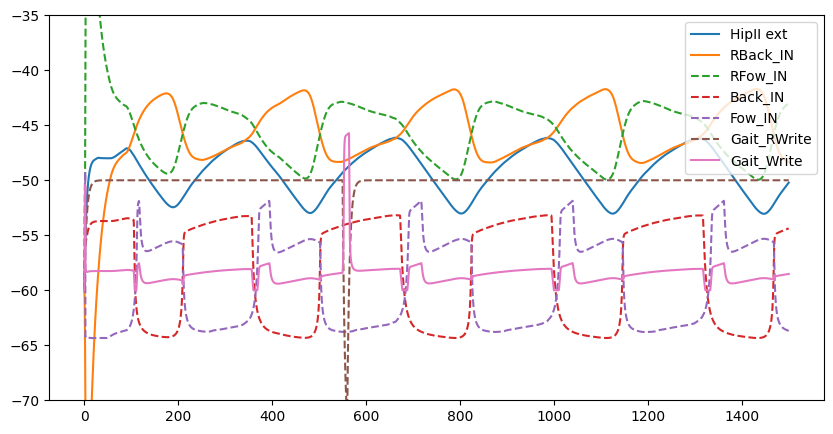

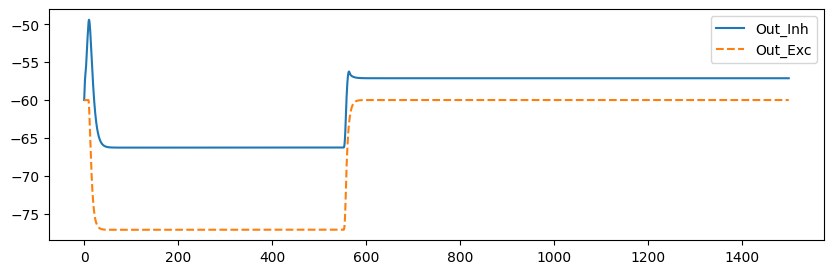

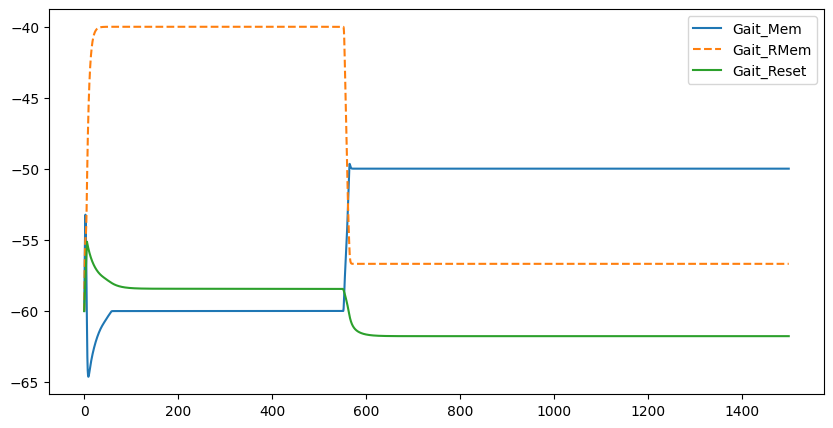

In [5]:
# PLOTS

plt.figure(figsize=(10,5))
plt.plot(t, data[:,0], label='HipII ext')
plt.plot(t, data[:,1], label='RBack_IN')
plt.plot(t, data[:,2], label='RFow_IN',linestyle="dashed")
plt.plot(t, data[:,3], label='Back_IN',linestyle="dashed")
plt.plot(t, data[:,4], label='Fow_IN',linestyle="dashed")
plt.plot(t, data[:,5], label='Gait_RWrite',linestyle="dashed")
plt.plot(t, data[:,6], label='Gait_Write')
plt.ylim(-70,-35)
plt.legend(loc='upper right')

plt.figure(figsize=(10,3))
plt.plot(t, data[:,10], label='Out_Inh')
plt.plot(t, data[:,11], label='Out_Exc', linestyle="dashed")
plt.legend()

plt.figure(figsize=(10,5))
plt.plot(t, data[:,7], label='Gait_Mem')
plt.plot(t, data[:,8], label='Gait_RMem', linestyle="dashed")
plt.plot(t, data[:,9], label='Gait_Reset')
plt.legend()

#plt.figure(figsize=(10,5))
#plt.plot(t, data[:,12], label='Fow_Splitter')
#plt.legend()